In [737]:
import pandas as pd
import numpy as np
import requests
import json
import sqlite3
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

Import bike station information.

In [738]:
url2='https://tor.publicbikesystem.net/ube/gbfs/v1/en/station_information'
stationInfo_df = pd.DataFrame(json.loads(requests.get(url2).text)['data']['stations'])
stationInfo_df['station_id'] = stationInfo_df['station_id'].astype(np.int64)
stationInfo_df.head()

,station_id,name,physical_configuration,lat,lon,altitude,address,capacity,rental_methods,groups,obcn,nearby_distance,post_code,cross_street
0,7000,Fort York Blvd / Capreol Ct,REGULAR,43.639832,-79.395954,0.0,Fort York Blvd / Capreol Ct,35,"[KEY, CREDITCARD, TRANSITCARD, PHONE]",[],647-643-9607,500.0,NaN,NaN
1,7001,Lower Jarvis St / The Esplanade,REGULAR,43.647992,-79.370907,0.0,Lower Jarvis St / The Esplanade,15,"[KEY, CREDITCARD, TRANSITCARD, PHONE]",[],416-617-9576,500.0,NaN,NaN
2,7002,St. George St / Bloor St W,REGULAR,43.667333,-79.399429,0.0,St. George St / Bloor St W,19,"[KEY, CREDITCARD, TRANSITCARD, PHONE]",[],647-643-9615,500.0,NaN,NaN
3,7003,Madison Ave / Bloor St W,REGULAR,43.667158,-79.402761,NaN,Madison Ave / Bloor St W,15,"[KEY, CREDITCARD, TRANSITCARD, PHONE]",[],647-631-4587,500.0,NaN,NaN
4,7004,University Ave / Elm St,REGULAR,43.656518,-79.389099,NaN,University Ave / Elm St,11,"[KEY, CREDITCARD, TRANSITCARD, PHONE]",[P7004-7047],647-643-9673,500.0,NaN,NaN


Connect to the SQLite database. This contains a log of all station statuses that is recored every 10 minutes.

In [739]:
conn = sqlite3.connect('bikeshareTO.db')
c = conn.cursor()

Load the database into a pandas dataframe.

In [740]:
df = pd.read_sql_query(
    'SELECT * FROM station_status',conn)

I'm going to check which stations has the largest standard deviation as an indicator of activity.

In [741]:
busyStations_df = df[['station_id','num_bikes_available']].groupby(by='station_id').std().sort_values(by='num_bikes_available',ascending=False).head(20)
busyStations_df.join(stationInfo_df[['station_id','name']].set_index('station_id'))

,num_bikes_available,name
station_id,,
7344,19.421278,Cherry Beach
7042,9.819874,Sherbourne St / Wellesley St E
7047,9.714019,University Ave / Gerrard St W
7000,9.602052,Fort York Blvd / Capreol Ct
7022,8.517809,Simcoe St / Queen St W
7168,8.061974,Queens Quay / Yonge St
7037,8.007471,Bathurst St / Dundas St W
7015,7.229134,King St W / Bay St (West Side)
7524,7.037000,Lisgar Park


For Cherry Beach, the bikes begin to get rented around 12pm.


Text(0.5, 0, 'Date (M-D-Hour)')

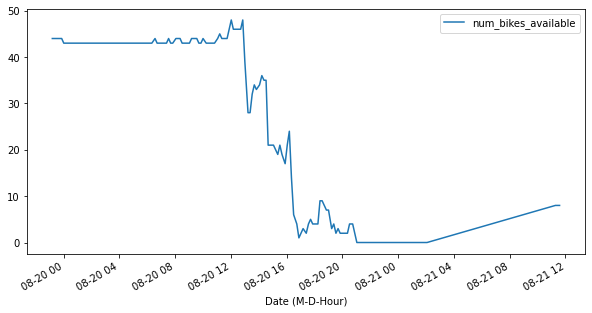

In [742]:
df = pd.read_sql_query(
    'SELECT * FROM station_status WHERE station_id=7344',conn)
df['last_reported'] = pd.to_datetime(df['last_reported'],unit='s') + pd.Timedelta(hours=-4)
ax = df.plot('last_reported','num_bikes_available',figsize=(10,5))
ax.set_xlabel('Date (M-D-Hour)')

For University Ave / Gerrard St W, the clear 8am-4pm work cycle is shown.

Text(0.5, 0, 'Date (M-D-Hour)')

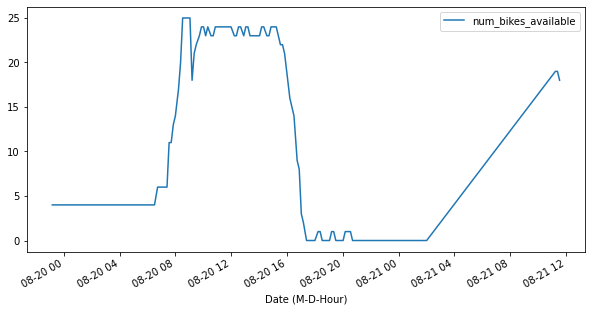

In [743]:
df = pd.read_sql_query(
    'SELECT * FROM station_status WHERE station_id=7047',conn)
df['last_reported'] = pd.to_datetime(df['last_reported'],unit='s') + pd.Timedelta(hours=-4)
ax = df.plot('last_reported','num_bikes_available',figsize=(10,5))
ax.set_xlabel('Date (M-D-Hour)')

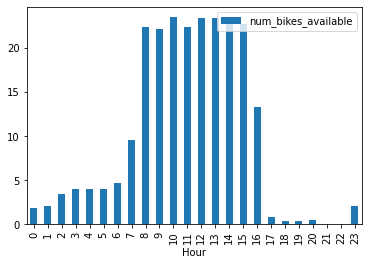

In [744]:
df['Hour'] = df['last_reported'].dt.hour
df.groupby(by='Hour').mean().reset_index().plot.bar('Hour','num_bikes_available')

I'm going to analyze the difference between bike availability before the beginning of the work cycle (4am-6am) and during the start of the work cycle (8am-10am). This will indicate where people are going.

In [745]:
df = pd.read_sql_query(
    'SELECT * FROM station_status',conn)
df['last_reported'] = pd.to_datetime(df['last_reported'],unit='s') + pd.Timedelta(hours=-4)
df['Hour'] = df['last_reported'].dt.hour
startHours = (df['Hour']<=10) & (df['Hour']>=8)
earlyHours = (df['Hour']<=6) & (df['Hour']>=4)
endHours = (df['Hour']<=20) & (df['Hour']>=18)
start_df = df[startHours].groupby(by='station_id').mean()
end_df = df[endHours].groupby(by='station_id').mean()
start_df

,num_bikes_available,num_bikes_disabled,num_docks_available,Hour
station_id,,,,
7000,29.166667,0.000000,5.833333,9.000000
7001,6.722222,0.000000,8.277778,8.944444
7002,10.888889,0.000000,8.111111,9.000000
7003,2.263158,1.947368,10.789474,9.052632
7004,10.277778,0.444444,0.277778,9.000000
...,...,...,...,...
7640,0.000000,0.000000,15.000000,9.000000
7641,6.000000,0.000000,9.000000,9.000000
7642,0.277778,0.000000,18.722222,8.944444


In [746]:
early_df = df[earlyHours].groupby(by='station_id').mean()
early_df

,num_bikes_available,num_bikes_disabled,num_docks_available,Hour
station_id,,,,
7000,33.111111,0.0,1.888889,5.000000
7001,13.705882,0.0,1.294118,5.058824
7002,1.388889,0.0,17.611111,5.000000
7003,4.000000,1.0,10.000000,5.000000
7004,4.111111,0.0,6.888889,5.111111
...,...,...,...,...
7640,0.000000,0.0,15.000000,5.000000
7641,6.000000,0.0,9.000000,5.000000
7642,2.000000,0.0,17.000000,4.944444


I'll subtract the results of the dataframes to get the average change in bike availabilty at each station. I divide the result by the capacity to normalize the results.

In [747]:
diff_df = (start_df - early_df).sort_values(by='num_bikes_available').join(stationInfo_df.set_index('station_id')[['name','capacity','lat','lon']])
diff_df['normalized_change'] = np.rint(diff_df['num_bikes_available']/ diff_df['capacity']*100)
diff_df = diff_df.sort_values(by='normalized_change')
diff_df

,num_bikes_available,num_bikes_disabled,num_docks_available,Hour,name,capacity,lat,lon,normalized_change
station_id,,,,,,,,,
7017,-7.833333,0.000000,7.833333,4.055556,Widmer St / Adelaide St W,11,43.647508,-79.391484,-71.0
7054,-6.611111,0.000000,6.611111,3.833333,Navy Wharf Ct. / Bremner Blvd.,11,43.640722,-79.391051,-60.0
7229,-6.888889,0.000000,6.888889,3.941176,Dundas St W / Roncesvalles Green P - SMART,12,43.653427,-79.451279,-57.0
7525,-3.888889,0.000000,3.888889,4.000000,Fennings St / Queen St W - SMART,7,43.643945,-79.421189,-56.0
7338,-6.000000,0.000000,6.000000,4.058824,Logan Ave / Bain Ave,11,43.672027,-79.347056,-55.0
...,...,...,...,...,...,...,...,...,...
7026,10.722222,0.833333,-11.555556,4.000000,Bay St / St. Joseph St,15,43.665527,-79.387499,71.0
7047,18.483660,0.588235,-19.071895,4.058824,University Ave / Gerrard St W,25,43.657763,-79.389165,74.0
7015,15.222222,0.000000,-15.222222,4.000000,King St W / Bay St (West Side),19,43.648520,-79.380576,80.0


## Map
I'll plot the results on a Folium map, where the red data points indicate stations that had a deficit of bikes and the green points represent the stations that had a surplus of bikes. The size of the markers represents the magnitude of the normalized change.

We can clearly see that the green (surplus) data points are centralized whereas the deficit are outside the downtown core and outskirts. The surplus is mainly clustered on University Avenue near the hospitals, and on Bay street by the Financial district.

In [748]:
import folium

m = folium.Map(location=[43.650033,-79.396555])
diff_df[diff_df['normalized_change']<=-5].apply(lambda row:folium.Circle(location=[row["lat"], 
                                                  row["lon"]], color='#FF0000', radius=np.abs(row['normalized_change']),fill=True, 
                                                                          tooltip=row['name']+"<br>Availability Change: "+str(row['normalized_change'])+"%<br> Capacity: "+str(row['capacity'])+"<br>Net Bikes: "+str(np.rint(row['num_bikes_available']))).add_to(m),
         axis=1)

diff_df[diff_df['normalized_change']>=5].apply(lambda row:folium.Circle(location=[row["lat"], 
                                                  row["lon"]], color='#008000', radius=np.abs(row['normalized_change']),fill=True, 
                                                                         tooltip=row['name']+"<br>Availability Change: "+str(row['normalized_change'])+"%<br> Capacity: "+str(row['capacity'])+"<br>Net Bikes: "+str(np.rint(row['num_bikes_available']))).add_to(m),
         axis=1)
m

In [749]:
m.save('plot1.png')

I'll do a similar analysis comparing the end of work hours (5pm-7pm) compared to the start of work hours (8am-10am). 

In [750]:
diff_df = (end_df - start_df).sort_values(by='num_bikes_available').join(stationInfo_df.set_index('station_id')[['name','capacity','lat','lon']])
diff_df['normalized_change'] = np.rint(diff_df['num_bikes_available']/ diff_df['capacity']*100)
diff_df = diff_df.sort_values(by='normalized_change').dropna()
diff_df

,num_bikes_available,num_bikes_disabled,num_docks_available,Hour,name,capacity,lat,lon,normalized_change
station_id,,,,,,,,,
7502,-12.898693,0.000000,12.898693,9.941176,University Ave / College St (East),14.0,43.659950,-79.389640,-92.0
7004,-9.944444,0.555556,9.388889,10.000000,University Ave / Elm St,11.0,43.656518,-79.389099,-90.0
7047,-22.316993,1.411765,20.905229,9.941176,University Ave / Gerrard St W,25.0,43.657763,-79.389165,-89.0
7062,-9.628655,0.000000,9.628655,9.947368,University Ave / College St (West),11.0,43.659226,-79.390213,-88.0
7344,-39.055556,0.000000,39.055556,10.000000,Cherry Beach,49.0,43.637764,-79.345359,-80.0
...,...,...,...,...,...,...,...,...,...
7114,6.888889,0.000000,-6.888889,10.000000,Carlton St / Parliament St,15.0,43.664524,-79.367930,46.0
7373,7.134503,0.000000,-7.134503,9.947368,George St / King St E,15.0,43.650955,-79.370700,48.0
7153,9.388889,0.000000,-9.388889,10.055556,Bloor St W / Christie St,19.0,43.663889,-79.418889,49.0


We can start to see some green points on the outskirts indicating that people are leaving work. A significant deficit is seen on University Ave as well.

In [751]:
m = folium.Map(location=[43.650033,-79.396555])
diff_df[diff_df['normalized_change']<=-5].apply(lambda row:folium.Circle(location=[row["lat"], 
                                                  row["lon"]], color='#FF0000', radius=np.abs(row['normalized_change']),fill=True, 
                                                                          tooltip=row['name']+"<br>Availability Change: "+str(row['normalized_change'])+"%<br> Capacity: "+str(row['capacity'])+"<br>Net Bikes: "+str(np.rint(row['num_bikes_available']))).add_to(m),
         axis=1)

diff_df[diff_df['normalized_change']>=5].apply(lambda row:folium.Circle(location=[row["lat"], 
                                                  row["lon"]], color='#008000', radius=np.abs(row['normalized_change']),fill=True, 
                                                                         tooltip=row['name']+"<br>Availability Change: "+str(row['normalized_change'])+"%<br> Capacity: "+str(row['capacity'])+"<br>Net Bikes: "+str(np.rint(row['num_bikes_available']))).add_to(m),
         axis=1)
m

## Hourly Heatmap of Bike Availability

In [755]:
hourly_df = df.set_index('station_id').join(stationInfo_df[['station_id','name','capacity']].set_index('station_id'))
hourly_df['Bike Station [Capacity]'] = hourly_df['name']+" ["+hourly_df['capacity'].astype(str).replace('\.0', '', regex=True)+']'
hourly_df['Fraction Available'] = hourly_df['num_bikes_available']/hourly_df['capacity']
hourly_df = hourly_df.groupby(by=['Hour','Bike Station [Capacity]']).mean().unstack()

In [756]:
temp_df = hourly_df['Fraction Available'].reindex(hourly_df['Fraction Available'].std().sort_values(ascending=False).index,axis=1)
temp_df

Bike Station [Capacity],University Ave / College St (East) [14],University Ave / Gerrard St W [25],King St W / Bay St (West Side) [19],University Ave / College St (West) [11],Cherry Beach [49],Queen St W / James St [11],Lower Jarvis St / The Esplanade [15],Bay St / St. Joseph St [15],Orde St / McCaul St - SMART [15],Sherbourne St / Wellesley St E [31],...,Davenport Rd / Bathurst St [31],The Queensway / High St - SMART [23],Marie Curtis Park [23],Woodbine Ave / O'Connor Dr - SMART [19],St Clarens Ave / Shirley Ave - SMART [15],Victoria Park Ave / Danforth Ave - SMART [19],Starspray Ave / Lawrence Ave E [23],Long Branch GO Station [33],Guildwood GO Station (North) [27],519 Church St - SMART [0]
Hour,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.072727,0.285088,0.181818,0.472527,0.000000,0.917949,0.211111,0.138462,0.784946,...,0.674938,0.675889,0.695652,0.368421,0.200000,0.289474,0.086957,0.909091,0.444444,inf
1,0.000000,0.080000,0.263158,0.123967,0.398887,0.000000,0.915152,0.133333,0.127273,0.790323,...,0.680352,0.673913,0.695652,0.368421,0.200000,0.287449,0.086957,0.909091,0.444444,inf
2,0.000000,0.137143,0.075188,0.233766,0.752187,0.000000,0.923810,0.075000,0.190476,0.801843,...,0.653226,0.657609,0.695652,0.368421,0.200000,0.271930,0.086957,0.909091,0.444444,inf
3,0.000000,0.160000,0.000000,0.272727,0.877551,0.000000,0.933333,0.066667,0.200000,0.806452,...,0.645161,0.652174,0.695652,0.368421,0.200000,0.263158,0.086957,0.909091,0.444444,inf
4,0.000000,0.160000,0.000000,0.272727,0.877551,0.000000,0.933333,0.066667,0.200000,0.806452,...,0.645161,0.652174,0.695652,0.368421,0.200000,0.263158,0.086957,0.909091,0.444444,inf
5,0.011905,0.160000,0.000000,0.272727,0.877551,0.000000,0.933333,0.066667,0.200000,0.790323,...,0.645161,0.652174,0.695652,0.368421,0.200000,0.263158,0.086957,0.909091,0.444444,inf
6,0.071429,0.186667,0.087719,0.400000,0.881633,0.000000,0.877778,0.122222,0.211111,0.704301,...,0.645161,0.652174,0.695652,0.368421,0.200000,0.263158,0.086957,0.909091,0.444444,inf
7,0.306122,0.382857,0.385965,0.742424,0.880952,0.000000,0.844444,0.522222,0.266667,0.654378,...,0.645161,0.652174,0.695652,0.368421,0.200000,0.263158,0.086957,0.909091,0.444444,inf
8,0.814286,0.896000,0.605263,0.924242,0.887755,0.151515,0.933333,0.688889,0.388889,0.541935,...,0.645161,0.652174,0.695652,0.368421,0.200000,0.263158,0.086957,0.909091,0.444444,inf


### The Top 30 Bike Stations with the Most Activity

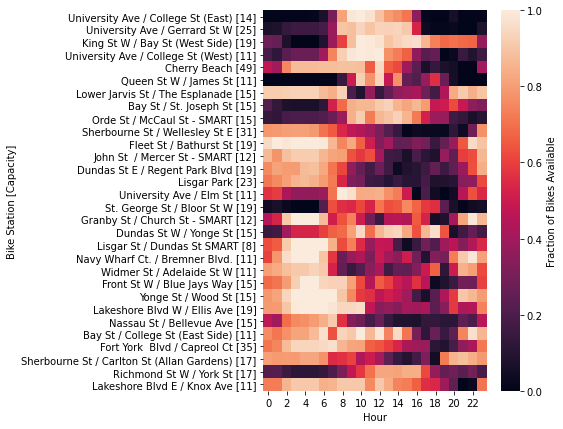

In [789]:
fig, ax = plt.subplots(figsize=(5,7))
sns.heatmap(temp_df.T.head(30), cbar_kws={'label': 'Fraction of Bikes Available'}, ax=ax, yticklabels=True)
plt.yticks(rotation=0);

### The Bottom 30 Bike Stations with the Least Activity

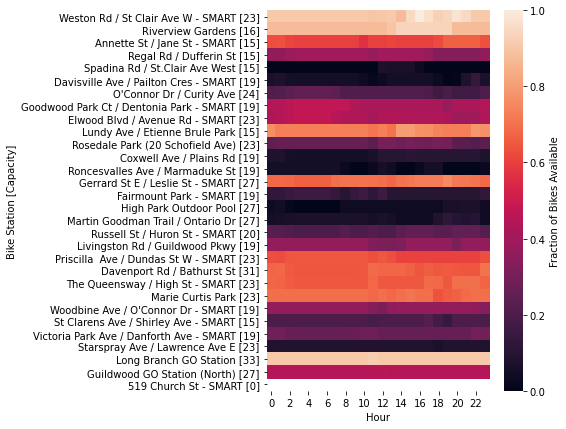

In [791]:
fig, ax = plt.subplots(figsize=(5,7))
sns.heatmap(temp_df.T.tail(30), cbar_kws={'label': 'Fraction of Bikes Available'}, ax=ax, vmin=0, vmax=1,yticklabels=True)
plt.yticks(rotation=0);